In [1]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Problem-1
Construct a linear regression of weight as predicted by height, using the
adults (age 18 or greater) from the Howell1 dataset. The heights listed below
were recorded in the !Kung census, but weights were not recorded for these
individuals. Provide predicted weights and 89% compatibility intervals for
each of these individuals. 

$$
\begin{array}{c|c|c|c}
\text { Individual } & \text { height } & \text { expected weight } & 89 \% \text { interval } \\
\hline 1 & 140 & & \\
2 & 160 & \\
3 & 175 & &
\end{array}
$$

In [2]:
howell_df = pd.read_csv("../data/Howell1.csv", sep=";")

In [3]:
howell_df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
def linear_model(heights: jnp.ndarray, weights: jnp.ndarray = None):
    '''
    This function will take the heights and compute the predicted
    weights
    '''
    m = numpyro.sample('slope', dist.Normal(0.7))
    b = numpyro.sample('intercept', dist.Normal(0.7))
    height_mu = jnp.mean(heights)
    weight_sigma =numpyro.sample('sigma', dist.Normal(0.7))
    weights_mu = b + m * (heights - height_mu)
    weights_pred = numpyro.sample('weight_sampled', dist.Normal(weights_mu,weight_sigma), obs=weights)
    return weights_pred


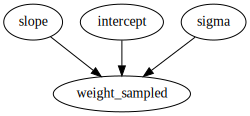

In [5]:
numpyro.render_model(linear_model, (), dict(heights=jnp.zeros(10)))

In [6]:
heights_data = jnp.array(howell_df['height'])
weights_data = jnp.array(howell_df['weight'])

In [29]:
from numpyro.infer import MCMC, NUTS
nuts_kernel = NUTS(linear_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=5000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, heights_data, weights_data, extra_fields=('potential_energy',))

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:02<00:00, 1850.36it/s, 3 steps of size 7.47e-01. acc. prob=0.91]


In [30]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept     33.98      0.24     33.98     33.60     34.38   2949.70      1.00
      sigma      5.16      0.17      5.16      4.91      5.45   2993.46      1.00
      slope      0.50      0.01      0.50      0.49      0.51   4733.31      1.00

Number of divergences: 0


In [31]:
samples = mcmc.get_samples()

In [32]:
slope = float(jnp.mean(samples["slope"]))
sigma = float(jnp.mean(samples["sigma"]))
intercept = float(jnp.mean(samples["intercept"]))

In [33]:
mean_height = float(jnp.mean(heights_data))

In [34]:
heights = jnp.array([140, 160, 175])
predicted_weights_mu = intercept + slope * (heights - mean_height)

In [35]:
predicted_weights_mu

DeviceArray([34.847324, 44.88054 , 52.40545 ], dtype=float32, weak_type=True)

# Problem-2

From the Howell1 dataset, consider only the people younger than 13 years old. Estimate the causal association between age and weight. Assume that age influences weight through two paths. First, age influences height, and height influences weight. Second, age directly influences weight through agerelated changes in muscle growth and body proportions.

Use a linear regression to estimate the total (not just direct) causal effect of each year of growth on weight. Be sure to carefully consider the priors. Try using prior predictive simulation to assess what they imply.

In [36]:
# select data for children aged less than 13
howell_df_u13 = howell_df[howell_df["age"] < 13]

In [57]:
# Setting up a model based on a dag which would look like:
# age -> height
# height -> weight
# age -> weight
def linear_model_2(ages: jnp.ndarray, weights: jnp.ndarray = None):
    '''
    This function will take the ages and compute the predicted
    weights
    '''
    m = numpyro.sample('slope', dist.Normal(0.7))
    b = numpyro.sample('intercept', dist.Normal(0.7))
    weight_sigma =numpyro.sample('sigma', dist.Normal(0.7))
    weights_mu = b + m * (ages)
    weights_pred = numpyro.sample('weight_sampled', dist.Normal(weights_mu,weight_sigma), obs=weights)
    return weights_pred

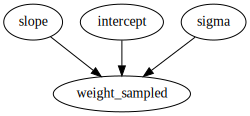

In [77]:
numpyro.render_model(linear_model_2, (), dict(ages=jnp.zeros(10)))

In [78]:
weights_data = jnp.array(howell_df_u13['weight'])
ages_data = jnp.array(howell_df_u13['age'])

In [79]:
from numpyro.infer import MCMC, NUTS
nuts_kernel = NUTS(linear_model_2)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=5000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, ages_data, weights_data, extra_fields=('potential_energy',))

sample: 100%|███████████████████████████████████████████████████████████████| 5500/5500 [00:03<00:00, 1709.79it/s, 3 steps of size 4.62e-01. acc. prob=0.91]


In [80]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept      6.64      0.34      6.64      6.09      7.20   2351.83      1.00
      sigma      2.56      0.16      2.55      2.31      2.82   2508.39      1.00
      slope      1.44      0.05      1.44      1.36      1.53   2374.19      1.00

Number of divergences: 0


The rate at which weight will change by age will most likely be in the range of (1.35 to 1.53)%

In [82]:
# lets do some fancy plotting and move on
howell_df_u13.describe()

,height,weight,age,male
count,146.000000,146.000000,146.000000,146.000000
mean,98.810729,14.693328,5.401370,0.486301
std,21.489527,5.722741,3.824657,0.501533
min,53.975000,4.252425,0.000000,0.000000
25%,84.455000,10.829509,2.000000,0.000000
50%,98.844100,13.792032,5.000000,0.000000
75%,114.300000,18.335039,8.000000,1.000000
max,147.955000,32.488527,12.000000,1.000000


In [85]:
latent_var_samples = mcmc.get_samples()

In [127]:
ages = [i for i in range(1,12)]
weights_mus = [age * latent_var_samples["slope"] + latent_var_samples["intercept"] for age in ages]

In [130]:
weights_mu = [age * jnp.mean(latent_var_samples["slope"]) + jnp.mean(latent_var_samples["intercept"]) for age in ages]
weights_mu_hdpi = jnp.array([numpyro.diagnostics.hpdi(weight_mu_samples, 0.89) for weight_mu_samples in weights_mus])

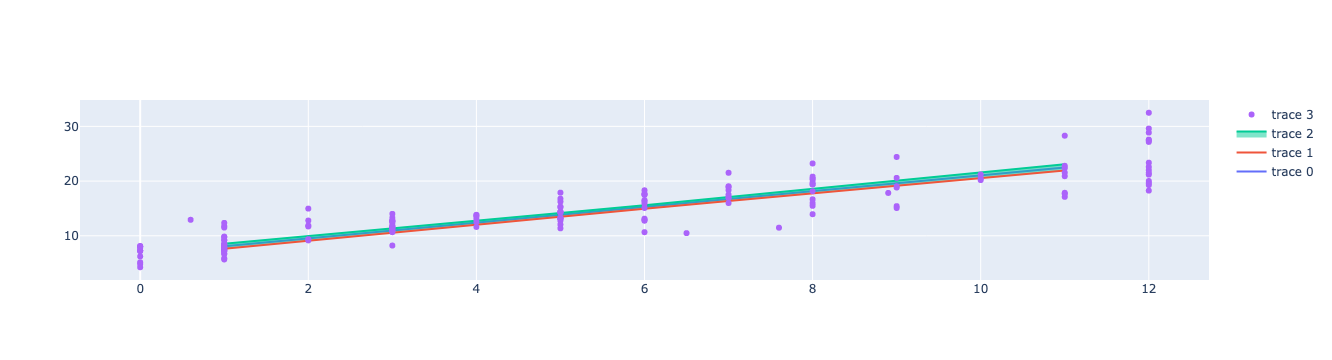

In [132]:
fig = go.Figure([
    go.Scatter(
        x = ages,
        y = weights_mu,
        mode = 'lines'
    ),
    go.Scatter(
        x = ages,
        y = weights_mu_hdpi[:,0],
        mode = 'lines'
    ),
    go.Scatter(
        x = ages,
        y = weights_mu_hdpi[:,1],
        mode = 'lines',
        fill='tonexty'
    ),
    go.Scatter(
        x = ages_data,
        y = weights_data,
        mode = 'markers'
    )
])
fig.show()

In [65]:
# Let's try building a full dag model and then find what the results would look line
def full_causal_model(ages: jnp.ndarray = None, weights: jnp.ndarray = None , heights: jnp.ndarray = None):
    '''
    This will show a full causal model we have in mind
    '''
    ages_sigma = numpyro.sample('age_sigma', dist.Normal(10))
    ages_mu = numpyro.sample('age_mu', dist.Normal(20))
    ages_pred = numpyro.sample('age', dist.Normal(ages_mu, ages_sigma), obs = ages)
    # heights
    m_a_h = numpyro.sample('age_height_slope', dist.Normal(0.7))
    b_a_h = numpyro.sample('age_height_intercept', dist.Normal(0.7))
    ages_mu = jnp.mean(ages_pred)
    heights_mu = b_a_h + m_a_h * (ages_pred - ages_mu)
    heights_sigma = numpyro.sample('height_sigma', dist.Normal(10))
    heights_pred = numpyro.sample('height', dist.Normal(heights_mu, heights_sigma), obs = heights)
    # weights
    m_w_a = numpyro.sample('weight_age_slope', dist.Normal(0.7))
    b_w_a = numpyro.sample('weight_age_intercept', dist.Normal(0.7))
    m_w_h = numpyro.sample('weight_height_slope', dist.Normal(0.7))
    b_w_h = numpyro.sample('weight_height_intercept', dist.Normal(0.7))
    weights_sigma = numpyro.sample('weight_sigma', dist.Normal(10))
    weights_mu = b_w_a + b_w_h + m_w_a * (ages_pred - ages_mu) + m_w_h * (heights_pred - heights_mu)
    weights = numpyro.sample('weight', dist.Normal(weights_mu, weights_sigma), obs = weights)
    return

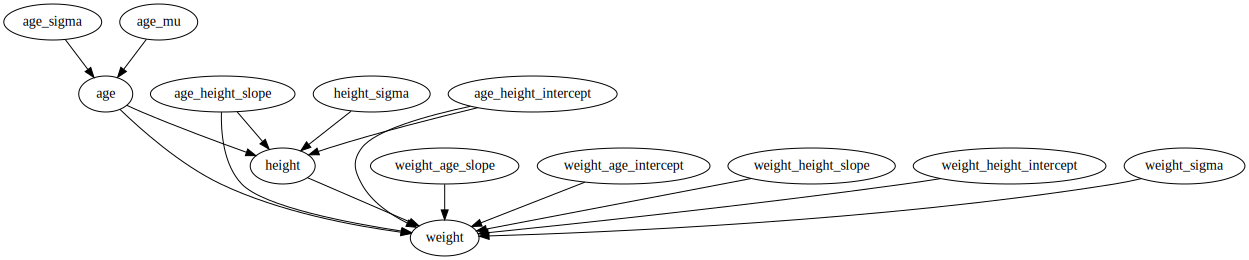

In [66]:
numpyro.render_model(full_causal_model, ())

In [68]:
weights_data = jnp.array(howell_df_u13['weight'])
ages_data = jnp.array(howell_df_u13['age'])
heights_data = jnp.array(howell_df_u13['height'])

In [75]:
from numpyro.infer import MCMC, NUTS
nuts_kernel = NUTS(full_causal_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=5000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, ages_data, weights_data, heights_data, extra_fields=('potential_energy',))

sample: 100%|██████████████████████████████████████████████████████████████| 5500/5500 [00:05<00:00, 1041.16it/s, 63 steps of size 8.73e-02. acc. prob=0.93]


In [76]:
mcmc.print_summary()


                               mean       std    median      5.0%     95.0%     n_eff     r_hat
     age_height_intercept     12.03      1.00     12.04     10.35     13.61   4844.75      1.00
         age_height_slope      3.56      0.60      3.57      2.59      4.56   3153.14      1.00
                   age_mu      7.39      0.47      7.36      6.67      8.18   3474.54      1.00
                age_sigma      4.79      0.39      4.76      4.13      5.40   3546.09      1.00
             height_sigma     34.04      0.56     34.05     33.08     34.91   4796.42      1.00
     weight_age_intercept     -1.26      0.88     -1.27     -2.63      0.22   4091.70      1.00
         weight_age_slope      1.02      0.13      1.03      0.82      1.24   3050.99      1.00
  weight_height_intercept     -1.24      0.87     -1.24     -2.64      0.20   3169.29      1.00
      weight_height_slope      0.20      0.01      0.20      0.18      0.22   3175.12      1.00
             weight_sigma      1.63    